In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Your existing VAE class (already defined as you've shown)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class Reshape(nn.Module):
    def __init__(self, *args):
        super(Reshape, self).__init__()
        self.shape = args
        
    def forward(self, x):
        return x.view(self.shape)

class Trim(nn.Module):
    def __init__(self):
        super(Trim, self).__init__()
    
    def forward(self, x):
        return x[:, :, :32, :32]
    
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, 3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, stride=2, padding=1)
        self.flatten = nn.Flatten()

        self.linear_mean = nn.Linear(2048, 100)
        self.linear_logvar = nn.Linear(2048, 100)

        self.linear = nn.Linear(100, 2048)
        self.reshape = Reshape(-1, 128, 4, 4)
        self.deconv1 = nn.ConvTranspose2d(128, 64, 3, stride=2, padding=0)
        self.deconv2 = nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1)
        self.deconv3 = nn.ConvTranspose2d(32, 3, 3, stride=2, padding=1)
        self.trim = Trim()

    def reparameterized(self, mean, var):
        eps = torch.randn(mean.size(0), mean.size(1)).to(device)
        z = mean + eps * torch.exp(var / 2.)
        return z

    def encode(self, x):
        x = F.silu(self.conv1(x))
        x = F.silu(self.conv2(x))
        x = self.conv3(x)
        x = self.flatten(x)
        mean = self.linear_mean(x)
        var = self.linear_logvar(x)
        z = self.reparameterized(mean, var)
        return mean, var, z

    def decode(self, z):
        z = self.linear(z)
        z = self.reshape(z)
        z = F.silu(self.deconv1(z))
        z = F.silu(self.deconv2(z))
        z = F.silu(self.deconv3(z))
        z = self.trim(z)
        z = torch.sigmoid(z)  # Ensuring pixel values are in range [0, 1]
        return z

    def forward(self, x):
        mean, var, z = self.encode(x)
        z = self.decode(z)
        return mean, var, z



In [2]:

# Instantiate the model and load the checkpoint
model = VAE().to(device)
checkpoint = torch.load('model1_log_50.pth')  # Make sure the path is correct
model.load_state_dict(checkpoint['model_state'])  # Load only model weights
model.eval()



VAE(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_mean): Linear(in_features=2048, out_features=100, bias=True)
  (linear_logvar): Linear(in_features=2048, out_features=100, bias=True)
  (linear): Linear(in_features=100, out_features=2048, bias=True)
  (reshape): Reshape()
  (deconv1): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2))
  (deconv2): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (deconv3): ConvTranspose2d(32, 3, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (trim): Trim()
)

torch.Size([60, 3, 32, 32])


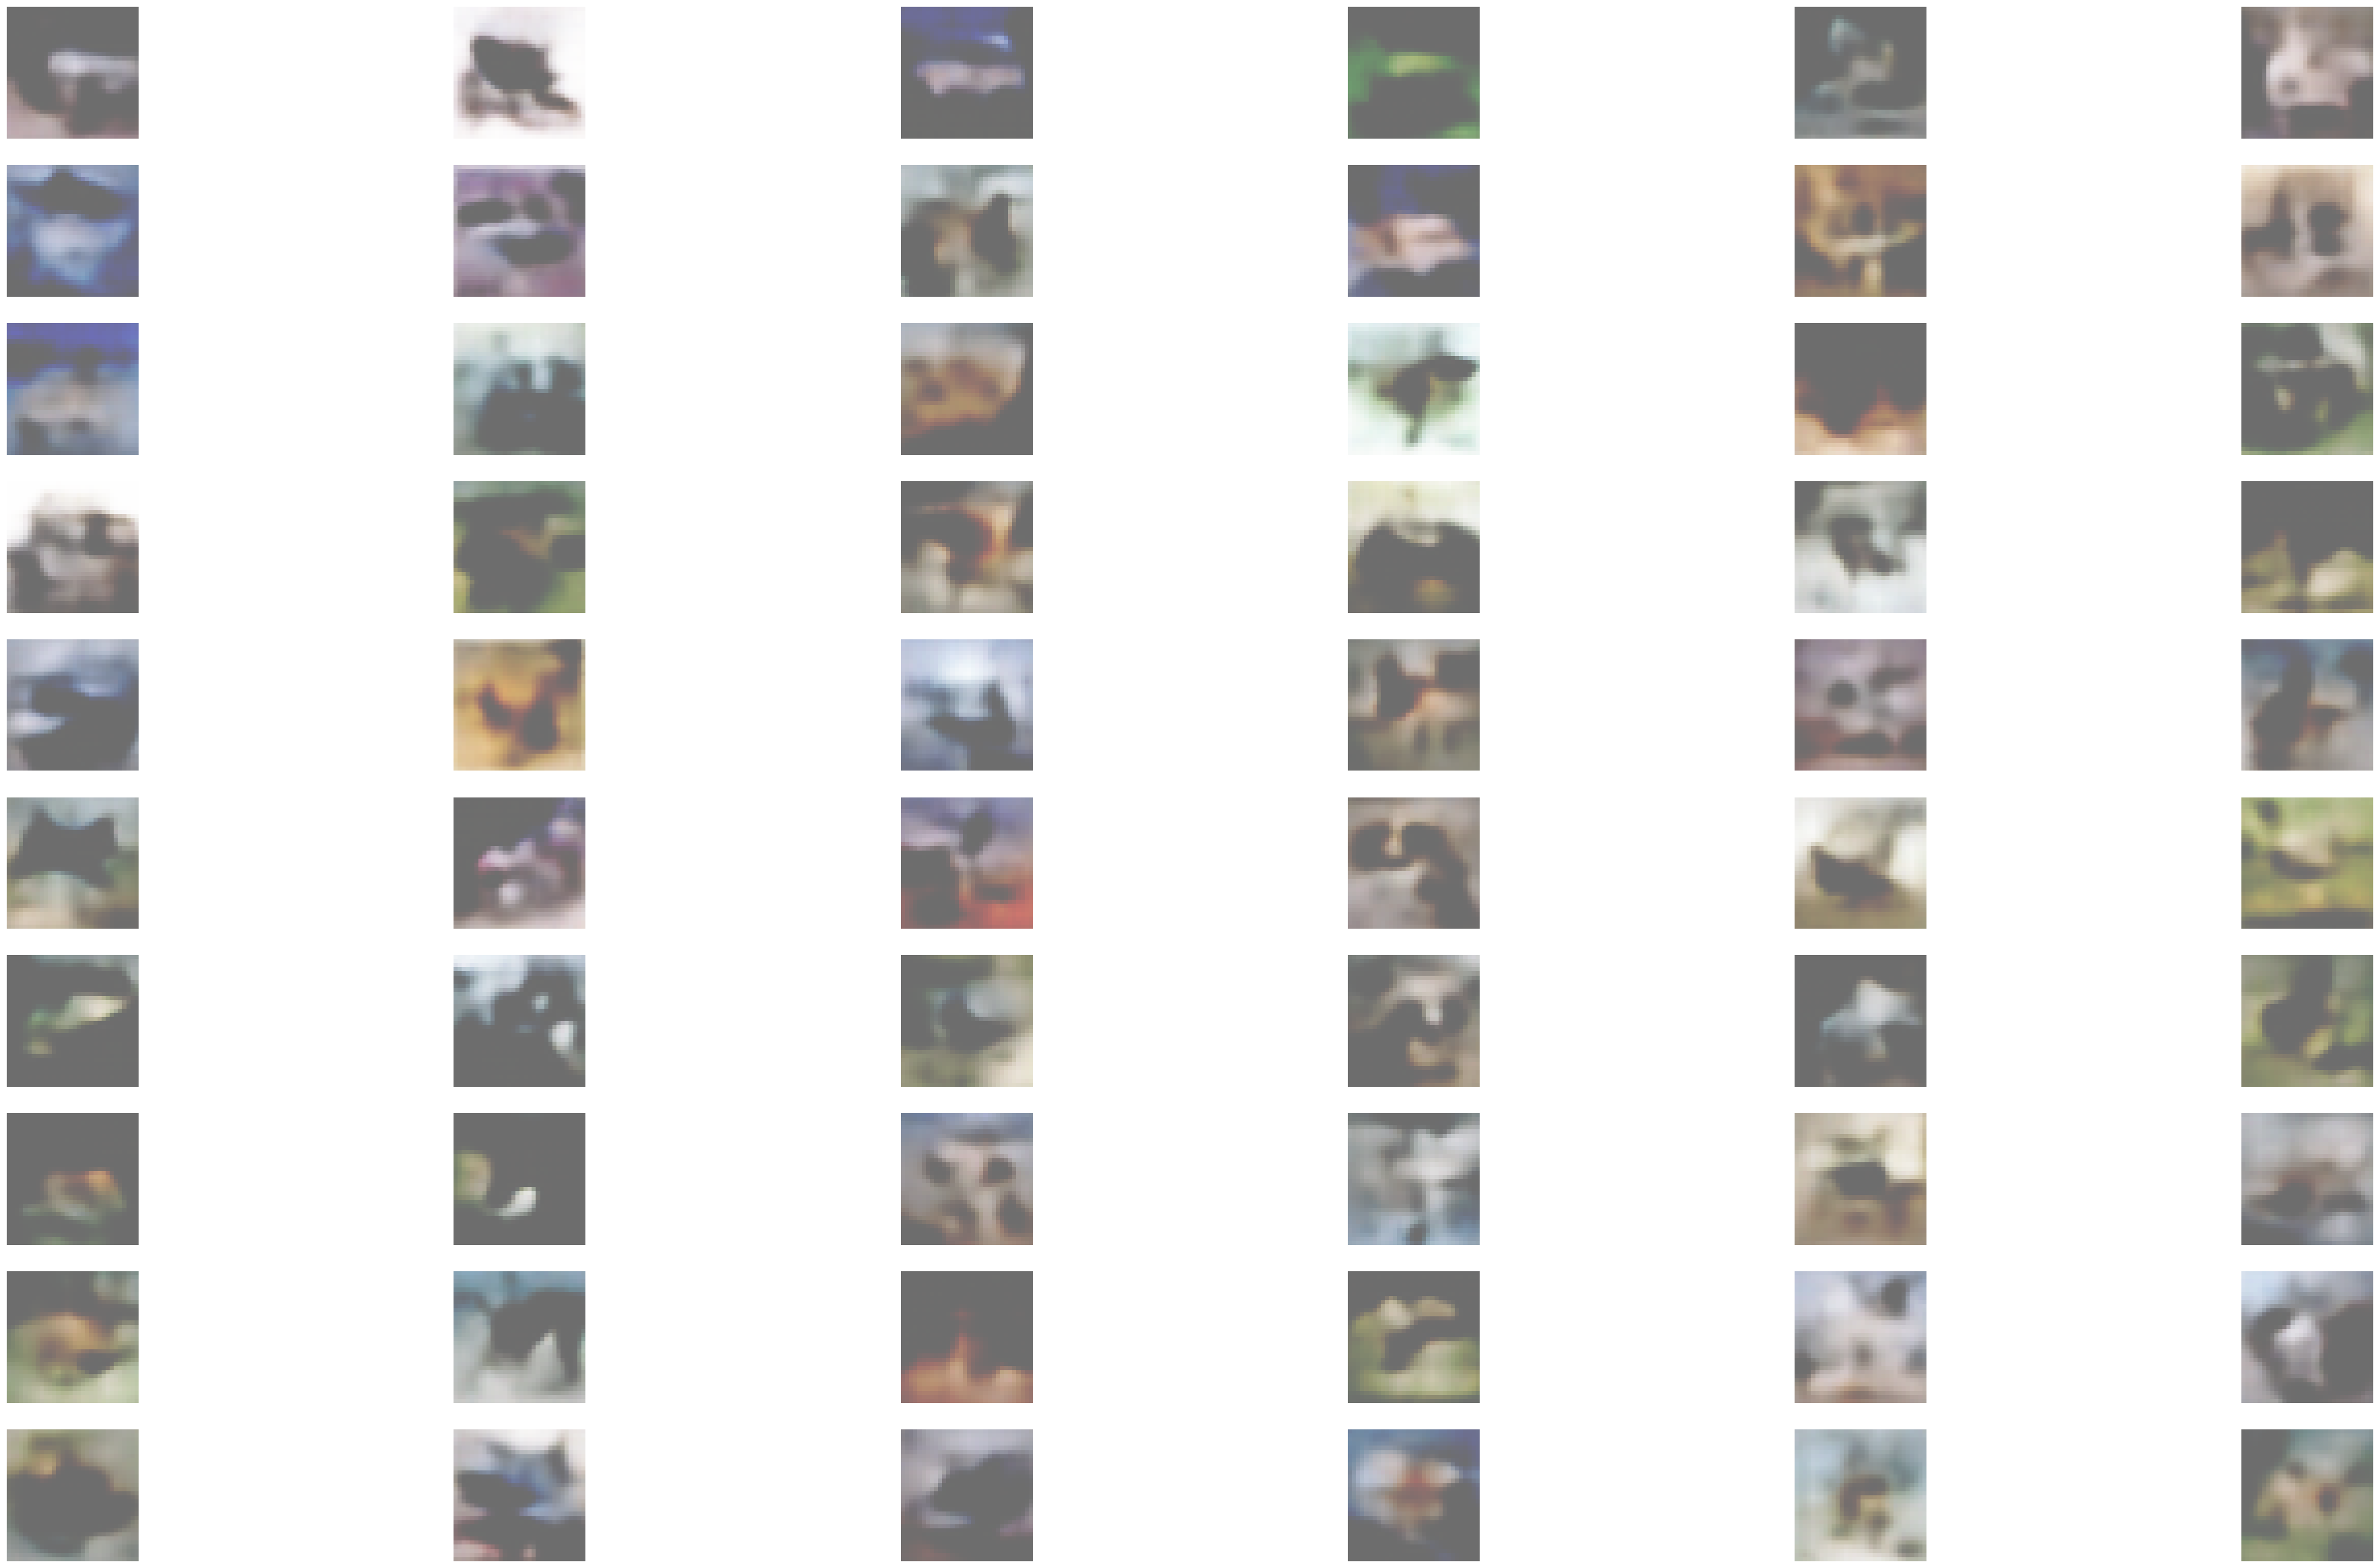

In [3]:
# Generating 60 images using the model
with torch.no_grad():
    latent_dim = 100  # Should match the latent dimension from your VAE architecture
    sixty_images_latent = torch.randn(60, latent_dim).to(device)  # Sample from the latent space
    sixty_images = model.decode(sixty_images_latent)  # Decode the latent vectors

    print(sixty_images.shape)  # Check the shape of generated images

    # Permute the images to get the correct order for plotting
    sixty_images = sixty_images.permute(0, 2, 3, 1).cpu().detach().numpy()  # Convert to numpy array for plotting

    # Plot the generated images
    fig, axs = plt.subplots(10, 6, figsize=(50, 30))

    for i in range(10):
        for j in range(6):
            idx = (6) * i + j  # Fix the index calculation
            axs[i][j].imshow(sixty_images[idx])
            axs[i][j].axis('off')

    plt.show()


In [4]:
import os
from PIL import Image
import torch
import numpy as np

# Define the target directory for the generated images
output_dir = os.path.expanduser('~/Documents/chris/master/1year_2sem/deep_l/vae_generated_dataset')

# Define the number of total images to generate
total_images = 60000  # Example: Same number as CIFAR-10
batch_size = 100  # Generate images in batches

latent_dim = 100  # Should match the VAE latent dimension

# Generate and save images
for i in range(0, total_images, batch_size):
    with torch.no_grad():
        latent_vectors = torch.randn(batch_size, latent_dim).to(device)  # Sample from latent space
        generated_images = model.decode(latent_vectors)  # Decode latent vectors to images
        #generated_images = torch.sigmoid(generated_images)  # Ensure values are in [0, 1]
        generated_images = generated_images.permute(0, 2, 3, 1).cpu().detach().numpy()  # Convert to numpy
        
        # Optional: Rescale pixel values to [0, 255] for PNG format
        generated_images = (generated_images * 255).astype(np.uint8)
    
    # Save each generated image
    for j in range(batch_size):
        image_index = i + j
        image = Image.fromarray(generated_images[j])
        image_filename = os.path.join(output_dir, f'image_{image_index}.png')
        image.save(image_filename)

print("Dataset generation complete!")


Dataset generation complete!
